%
\section{Classification Dataset: Kaggle Congressional Voting (\href{https://www.kaggle.com/c/184702-tu-ml-ss-21-congressional-voting/overview}{link to dataset})}
The Congressional Voting dataset is used for classification, it is a prediction on the party (republican or democrat) for politicians of the congress. It consists of 218 samples and 17 attributes where 15 attributes are given as string values (but corresponding to booleans) and 1 further as numerical value, the id of the row, which is not relevant so we drop it during the preprocessing step. The label is an ordinal value, "democrat" or "republican", and during the preprocessing step we transform it to respectively 0 and 1 value, and we replace "y" and "n" by 1 and 0. Hence, we have now only binary values. The description of the training dataset is the following {insert figure}.
We can see that there are some missing values, and we have the repartition of missing values among samples with the following table {insert table}. We can notice that the feature "export-administration-act-south-africa" is the most incomplete one, with 23% missing values, the other features having less than 11% missing values.
We decide to delete the samples with too many missing values (4 or more) because they are a few (8/218, less than 4%) and we suppose that it is not a great loss of data and it could be dangerous to keep too incomplete data because we fill every missing value randomly with 1 or 0 during the preprocessing step. When we tested with and without deleting the missing values, it seemed that we were right, it increased the accuracy by at least 10% for each algorithm. 
We also tried to impute them with a multivariate feature imputation, but the results were better with the random method (at least 15% of decrease in accuracy for each algorithm).

We have to notice about this dataset that the false negatives and false positives show no theoritical difference: we do not have to privilege one over the other. So the performance by class should be barely the same. What is more, we can see that the training dataset is inbalanced, so we will use balanced indicators (such as balanced accuracy and f1 score), and make sure that our precision and recall are close.

In [1]:
import pandas as pd
import random
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

training = pd.read_csv("./CongressionalVotingID.shuf.lrn.csv")
training_init = training.copy()

In [2]:
#preprocessing

def transform_to_binary(data) :
    #we drop the ID column which is not relevant
    d = data.drop('ID', axis=1)

    #we transform yes in 1 and no in 0, we convert "unknown" in NaN value and republican in 1 and democrat in 0, thus we have 
    #only binary values
    d = d.applymap(lambda x : 1 if x == "y" else (0 if x == "n" else (np.nan if x == "unknown" else (1 if x == "republican" else 0))))
    return d
    
def clean_rows(training, thres) :
    #only rows with at least 14 known values
    return training.dropna(axis=0, thresh=thres, subset=None, inplace=False)

def imputate(data, imputation) :
    # imputation
    imp = IterativeImputer(max_iter=10, random_state=0)
    if (imputation) :
        try:
            t = data.drop('class', axis=1)
        except:
            # it's the test set and we already have trained our imputation function
            print("HERE")
            array = np.round(imp.transform(data))
            data = pd.DataFrame(array, columns = data.columns)
        else:
            # we fit the multivariate feature imputation
            imp.fit(t)
            # we use it on training dataset
            array = np.round(imp.transform(t))
            t = pd.DataFrame(array, columns = t.columns)
            t.index = data.index
            t['class'] = data['class']
            data = t
    else :
        #we transform unknown values in 1 or 0 randomly
        data = data.fillna(random.randint(0,1))
    return data
    
        
def number_of_samples_per_number_of_missing_values(data) :
    # count how many rows have 'x' missing values
    m = data.copy()
    n = m.isna().sum(axis=1)
    n.name = "missing values in row"
    d = n.value_counts(sort=False)
    return d

def plot_count(data) :
    
    DF=[]
    for i in range(1, len(data.columns)) :
        DF.append(data[data.columns[i]].value_counts(dropna=False))
    df = pd.concat(DF, axis=1)
    df = df.transpose()
    if len(df.columns) == 3 :
        df.columns = ["No","Yes","Unknown"]
    else :
        df.columns = ["No","Yes"]
    
    df.plot(kind='bar', figsize = (15,10))
    
    plt.title("Number of samples per class")
    plt.ylabel('Count')
    plt.gca().xaxis.set_tick_params(rotation=90)

def plot_result_classes(data) :
    countplt, ax = plt.subplots(figsize = (15,10))
    ax = sns.countplot(data=data, x='class')
    ax.set_title("#Votes")
    ax.set_xticklabels(["democrat","republican"], rotation=45)
    
def plot_decisions(data, missing_values) :
    
    DF=[]
    F=[]
    for i in range(1, len(data.columns)) :
        DF.append(data.groupby(data.columns[i])['class'].mean())
        F.append(data[data.columns[i]].mean())
    
    df = pd.concat(DF, axis=1)
    df = df.transpose()
    df.index = data.columns[1:]
    df["final decision"] = F
    
    if missing_values :
        df.columns = ["no","yes","final decision"]
    else :
        df.columns = ["no","yes","unknown","final decision"]

    df.plot(kind='bar', figsize = (15,10))
        
    title = "Who took the decision ? Close to 1: decision taken by republicans. Close to 0: decision taken by democrats. Green bar : decision finally taken if > 0.5."
    plt.title(title)
    plt.ylabel('Relative part of republicans in a vote / Green : percentage of yes')
    plt.gca().xaxis.set_tick_params(rotation=90)

In [1185]:
training = transform_to_binary(training)
number_of_samples_per_number_of_missing_values(training)

0     118
1      61
2      21
3      10
4       1
5       2
6       2
9       1
14      1
15      1
Name: missing values in row, dtype: int64

In [1186]:
training.describe()

,class,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-crporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
count,218.000000,211.000000,194.000000,209.000000,211.000000,212.000000,213.000000,211.000000,213.000000,209.000000,216.000000,206.000000,203.000000,206.000000,210.000000,199.000000,168.000000
mean,0.366972,0.459716,0.541237,0.598086,0.407583,0.504717,0.629108,0.559242,0.591549,0.511962,0.527778,0.398058,0.369458,0.529126,0.595238,0.437186,0.845238
std,0.483088,0.499560,0.499586,0.491462,0.492553,0.501161,0.484182,0.497659,0.492705,0.501057,0.500387,0.490690,0.483851,0.500367,0.492019,0.497290,0.362759
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


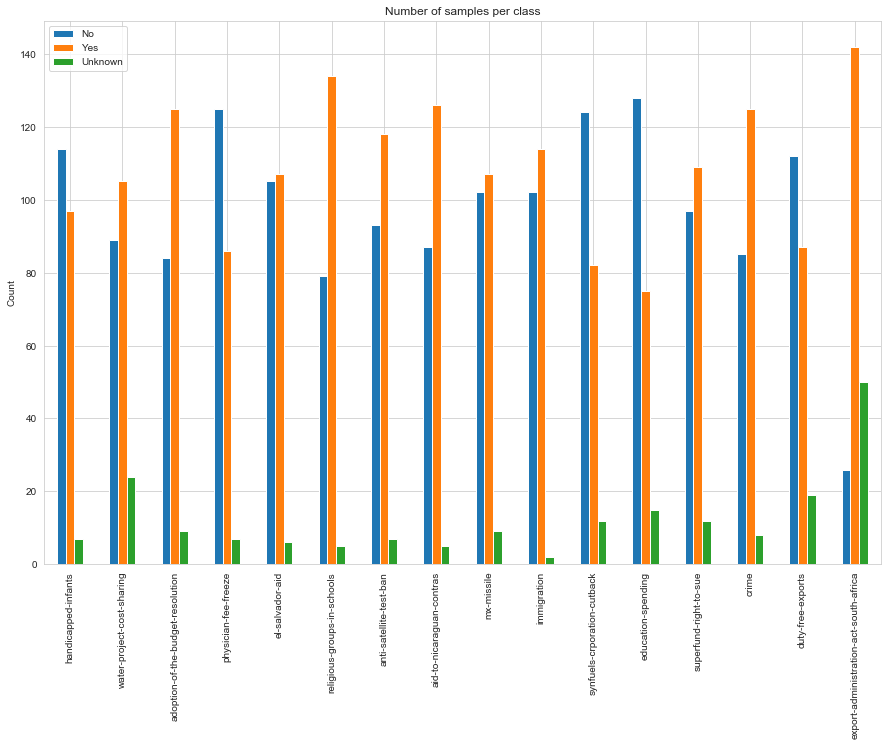

In [1187]:
plot_count(training)

In [1188]:
training = clean_rows(training, 14)
training = imputate(training, False)
training.describe()

,class,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-crporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
count,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000
mean,0.361905,0.461905,0.485714,0.585714,0.400000,0.500000,0.614286,0.552381,0.580952,0.490476,0.533333,0.385714,0.347619,0.509524,0.580952,0.414286,0.676190
std,0.481700,0.499738,0.500990,0.493775,0.491069,0.501195,0.487927,0.498437,0.494582,0.501104,0.500080,0.487927,0.477352,0.501104,0.494582,0.493775,0.469046
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,1.000000,0.000000,0.500000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


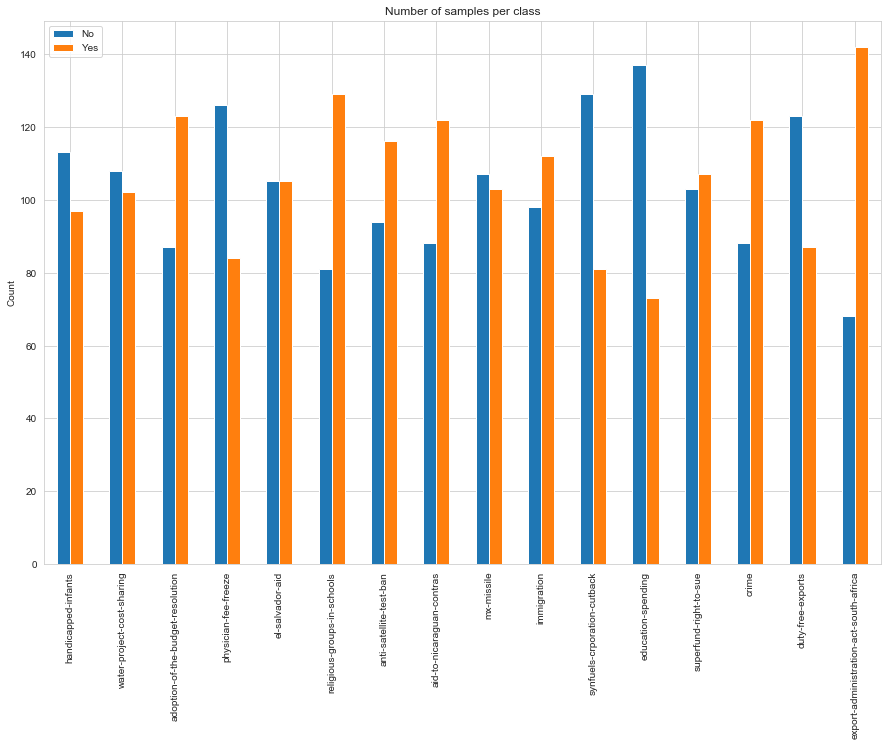

In [1189]:
plot_count(training)

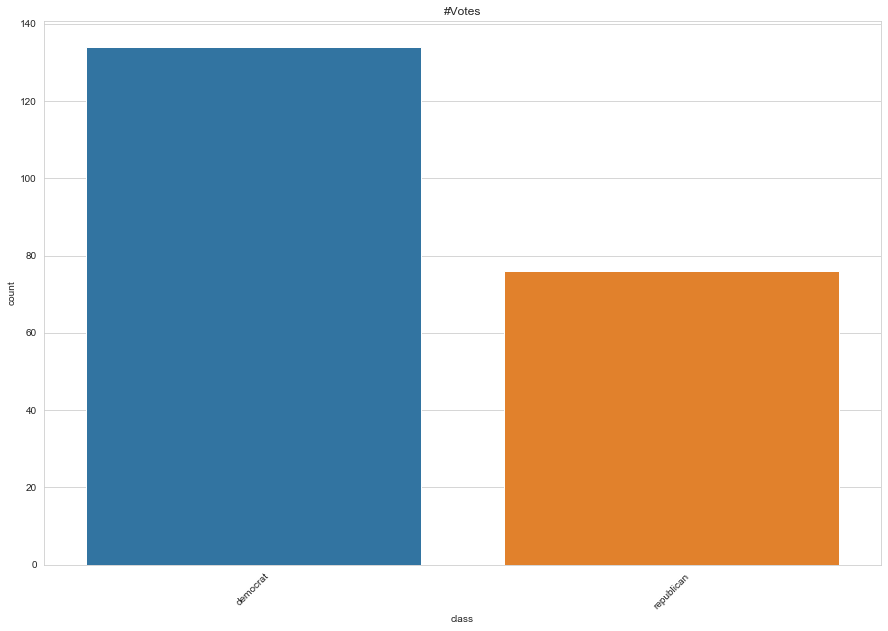

In [1190]:
plot_result_classes(training)

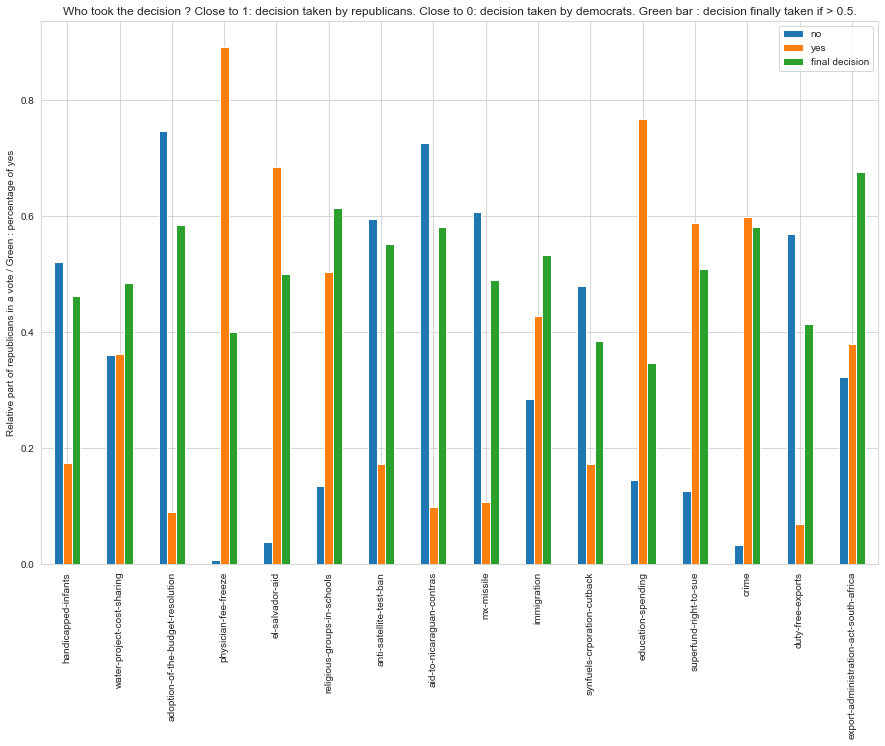

In [1191]:
plot_decisions(training, True)

In [1192]:
# training models

In [1193]:
from sklearn.model_selection import train_test_split

def preprocessing(thres, imp) :
    training = transform_to_binary(training_init)
    training = clean_rows(training, thres)
    training = imputate(training, imp)
    
    train_target = training.drop('class', axis=1)
    train_set, test_set = train_test_split(training, test_size=0.2, random_state=42)
    train = np.array(train_set)[:,1:]
    train_target = np.array(train_set)[:,0]
    test = np.array(test_set)[:,1:]
    test_target = np.array(test_set)[:,0]
    
    return train, train_target, test, test_target

In [1194]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report , confusion_matrix , balanced_accuracy_score , precision_score , recall_score , f1_score
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV, cross_val_score


import seaborn as sns
sns.set_style('whitegrid')

### Variables for performance analysis ###

def create_perceptron(train_data, target, grid=[], **kwargs):
    if grid != []:
        clf = GridSearchCV(Perceptron(), grid, refit = True, verbose = 3,n_jobs=2)
    else:
        clf = Perceptron(**kwargs)
    clf.fit(train_data, target)
    return clf

def create_rnd_forrest(train_data, target, grid=[], **kwargs):
    if grid != []:
        clf = GridSearchCV(RandomForestClassifier(), grid, refit = True, verbose = 3,n_jobs=2)
    else:
        clf = RandomForestClassifier(**kwargs)
    clf.fit(train_data, target)
    return clf

def create_nb(train_data, target):
    clf =MultinomialNB()
    clf.fit(train_data , target)
    return clf
    
def evaluate_algo(algo, test_data, test_target, train_data, train_target):
    
    print(algo)
    pred_test  = algo.predict(test_data)
    pred_train = algo.predict(train_data)
    
    # outputs
    metrics = {"accuracy": 0, "roc_auc": 0, "f1": 0, "precision": 0, "recall": 0}
    
    # accuracy
    if (balance) :
        metrics["accuracy"] = cross_val_score(ppn, train, train_target, scoring="balanced_accuracy", cv=10, n_jobs=3).mean()
        print("cross validation of balanced accuracy is {:.5} %".format(metrics["accuracy"]*100))
    else :
        metrics["accuracy"] = 100*cross_val_score(ppn, train, train_target, scoring="accuracy", cv=10, n_jobs=3).mean()
        print("cross validation of accuracy is {:.5} %".format(metrics["accuracy"]*100))
    
    # confusion matrix
    cmat = confusion_matrix(test_target, pred_test)
    cmat_train = confusion_matrix(train_target, pred_train)
    
    # report of metrics
    for score in ["roc_auc", "f1", "precision", "recall"]:
        cvs = cross_val_score(algo, train, train_target, scoring=score, cv=5, n_jobs=3).mean()
        print(score + " : "+ str(cvs))
        metrics[score] = cvs
    
    # plot of the confusion matrix
    plt.figure(figsize = (6, 6))
    sns.heatmap(cmat, annot = True, 
                cmap = 'Paired', 
                cbar = False, 
                fmt="d", 
                xticklabels=['Democrat', 'Republican'], 
                yticklabels=['Democrat', 'Republican']);
    
    return metrics

In [1195]:
# test of different preprocessing methods with the optimal parameters 

param_grid = {'eta0': [0.1,0.2,0.3,0.4],  
              'early_stopping': [True, False],
              'max_iter':[10,20,30,100],
              'tol':[1e-4,1e-3,1e-2,1e-1]}  

L = []
for imputation in [True, False] :
    for thres in range(6,17,2) :
        training = training_init.copy()
        train, train_target, test, test_target = preprocessing(thres, imputation)
        ppn = create_perceptron(train, train_target, grid = param_grid)
        text = "imputation: " + str(imputation) + ", threshold = " + str(thresh)
        params = ppn.best_params_
        print(text)
        print(params) 
        L.append((text,params,[train, train_target, test, test_target]))

C:\Users\saeny\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 128 candidates, totalling 384 fits


[Parallel(n_jobs=2)]: Done  30 tasks      | elapsed:    3.6s
[Parallel(n_jobs=2)]: Done 384 out of 384 | elapsed:    4.7s finished
C:\Users\saeny\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


imputation: True, threshold = 6
{'early_stopping': False, 'eta0': 0.3, 'max_iter': 10, 'tol': 0.1}


C:\Users\saeny\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 128 candidates, totalling 384 fits


[Parallel(n_jobs=2)]: Done 384 out of 384 | elapsed:    1.1s finished
C:\Users\saeny\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


imputation: True, threshold = 6
{'early_stopping': False, 'eta0': 0.3, 'max_iter': 10, 'tol': 0.1}


C:\Users\saeny\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 128 candidates, totalling 384 fits


[Parallel(n_jobs=2)]: Done 384 out of 384 | elapsed:    1.1s finished
C:\Users\saeny\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\saeny\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


imputation: True, threshold = 6
{'early_stopping': True, 'eta0': 0.1, 'max_iter': 10, 'tol': 0.0001}


C:\Users\saeny\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 128 candidates, totalling 384 fits


[Parallel(n_jobs=2)]: Done 384 out of 384 | elapsed:    1.2s finished
C:\Users\saeny\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


imputation: True, threshold = 6
{'early_stopping': True, 'eta0': 0.1, 'max_iter': 10, 'tol': 0.0001}


C:\Users\saeny\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 128 candidates, totalling 384 fits


[Parallel(n_jobs=2)]: Done 384 out of 384 | elapsed:    1.3s finished
C:\Users\saeny\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\saeny\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


imputation: True, threshold = 6
{'early_stopping': False, 'eta0': 0.1, 'max_iter': 10, 'tol': 0.001}
Fitting 3 folds for each of 128 candidates, totalling 384 fits


[Parallel(n_jobs=2)]: Done 384 out of 384 | elapsed:    1.1s finished
C:\Users\saeny\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\saeny\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


imputation: True, threshold = 6
{'early_stopping': True, 'eta0': 0.3, 'max_iter': 10, 'tol': 0.0001}
Fitting 3 folds for each of 128 candidates, totalling 384 fits


[Parallel(n_jobs=2)]: Done 384 out of 384 | elapsed:    1.2s finished
C:\Users\saeny\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\saeny\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


imputation: False, threshold = 6
{'early_stopping': True, 'eta0': 0.1, 'max_iter': 10, 'tol': 0.0001}
Fitting 3 folds for each of 128 candidates, totalling 384 fits


[Parallel(n_jobs=2)]: Done 384 out of 384 | elapsed:    1.2s finished
C:\Users\saeny\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\saeny\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


imputation: False, threshold = 6
{'early_stopping': False, 'eta0': 0.1, 'max_iter': 10, 'tol': 0.1}
Fitting 3 folds for each of 128 candidates, totalling 384 fits


[Parallel(n_jobs=2)]: Done 384 out of 384 | elapsed:    1.4s finished
C:\Users\saeny\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\saeny\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


imputation: False, threshold = 6
{'early_stopping': True, 'eta0': 0.1, 'max_iter': 10, 'tol': 0.0001}
Fitting 3 folds for each of 128 candidates, totalling 384 fits


[Parallel(n_jobs=2)]: Done 384 out of 384 | elapsed:    1.3s finished
C:\Users\saeny\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\saeny\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


imputation: False, threshold = 6
{'early_stopping': False, 'eta0': 0.1, 'max_iter': 20, 'tol': 0.0001}
Fitting 3 folds for each of 128 candidates, totalling 384 fits


[Parallel(n_jobs=2)]: Done 384 out of 384 | elapsed:    1.2s finished
C:\Users\saeny\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\saeny\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


imputation: False, threshold = 6
{'early_stopping': False, 'eta0': 0.3, 'max_iter': 20, 'tol': 0.0001}
Fitting 3 folds for each of 128 candidates, totalling 384 fits
imputation: False, threshold = 6
{'early_stopping': False, 'eta0': 0.3, 'max_iter': 10, 'tol': 0.0001}


[Parallel(n_jobs=2)]: Done 384 out of 384 | elapsed:    1.2s finished
C:\Users\saeny\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


C:\Users\saeny\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\saeny\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\saeny\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


imputation: False, threshold = 6
{'early_stopping': True, 'eta0': 0.1, 'max_iter': 10, 'tol': 0.0001}


Perceptron(alpha=0.0001, class_weight=None, early_stopping=True, eta0=0.1,
           fit_intercept=True, max_iter=10, n_iter_no_change=5, n_jobs=None,
           penalty=None, random_state=0, shuffle=True, tol=0.0001,
           validation_fraction=0.1, verbose=0, warm_start=False)
cross validation of balanced accuracy is 92.051 %
roc_auc : 0.9649184149184149
f1 : 0.9099999999999999
precision : 0.9833333333333332
recall : 0.8505494505494505


{'accuracy': 0.9205128205128206,
 'roc_auc': 0.9649184149184149,
 'f1': 0.9099999999999999,
 'precision': 0.9833333333333332,
 'recall': 0.8505494505494505}

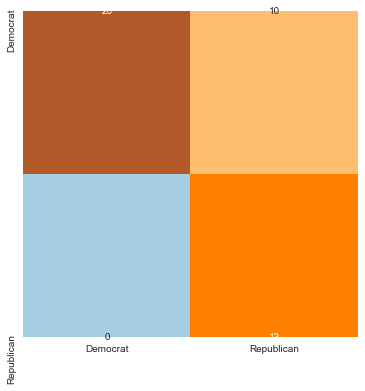

In [1197]:
prepro_text = ""
parameters = None
datasets = []
score = 0
for (text, params, prepro) in L :
    train, train_target, test, test_target = prepro[0], prepro[1], prepro[2], prepro[3]
    ppn = create_perceptron(train, train_target, **params)
    new_score = cross_val_score(ppn, train, train_target, scoring="accuracy", cv=5, n_jobs=3).mean()
    if new_score > score :
        score = new_score
        prepro_text = text
        parameters = params
        datasets = prepro
    #evaluate_algo(ppn, test, test_target, train, train_target)
print(best_preprocessing)
print(parameters)
print("\n")

train, train_target, test, test_target = datasets[0], datasets[1], datasets[2], datasets[3]
ppn = create_perceptron(train, train_target, **parameters)
evaluate_algo(ppn, test, test_target, train, train_target)

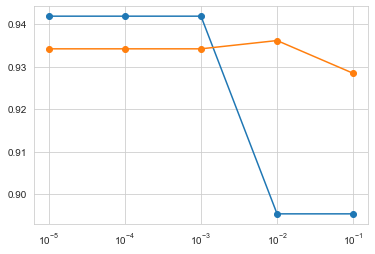

In [1223]:
# stopping criterion
import warnings
warnings.filterwarnings('ignore')
vals      = np.array([1e-5,1e-4,1e-3,1e-2,1e-1])
scores    = []
scores_cv = []
for x in vals:
    ppn = create_perceptron(train, train_target, eta0=0.1, max_iter=10,tol=x)
    scores.append(ppn.score(train, train_target))
    scores_cv.append(cross_val_score(ppn, train, train_target,scoring="balanced_accuracy", cv=10).mean())
plt.semilogx(vals, scores,"o-")
plt.semilogx(vals, scores_cv,"o-")

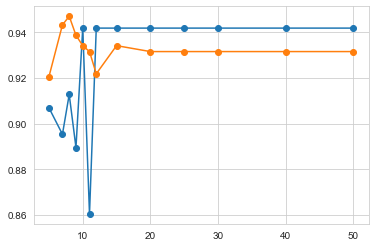

In [1221]:
# maximum iterations
vals      = np.array([5, 7, 8, 9, 10, 11, 12, 15, 20, 25, 30, 40, 50])
scores    = []
scores_cv = []
for x in vals:
    ppn = create_perceptron(train, train_target, eta0=0.1, max_iter=x,tol=0.001)
    scores.append(ppn.score(train, train_target))
    scores_cv.append(cross_val_score(ppn, train, train_target,scoring="balanced_accuracy", cv=10).mean())
plt.plot(vals, scores,"o-")
plt.plot(vals, scores_cv,"o-")

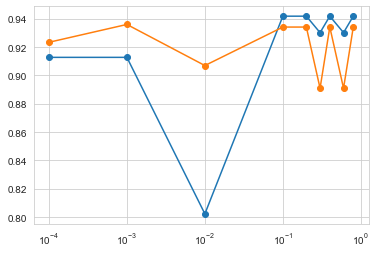

In [1225]:
#learning rate
vals      = np.array([1e-4, 1e-3, 0.01, 0.1, 0.2, 0.3, 0.4, 0.6, 0.8])
scores    = []
scores_cv = []
for x in vals:
    ppn = create_perceptron(train, train_target, eta0=x, max_iter=10,tol=0.001)
    scores.append(ppn.score(train, train_target))
    scores_cv.append(cross_val_score(ppn, train, train_target,scoring="balanced_accuracy", cv=10).mean())
plt.semilogx(vals, scores,"o-")
plt.semilogx(vals, scores_cv,"o-")

In [ ]:
# penalty parameter
vals_names = ["l2","l1","elasticnet","None"]
vals       = [0, 1, 2, 3]
scores    = []
scores_cv = []
for x in vals_names:
    ppn = create_perceptron(train, train_target, eta0=0.1, max_iter=10,tol=0.001, penalty=x)
    scores.append(ppn.score(train, train_target))
    scores_cv.append(cross_val_score(ppn, train, train_target,scoring="accuracy", cv=10).mean())
plt.plot(vals, scores,"o-")
plt.plot(vals, scores_cv,"o-")

In [ ]:
param_grid = {'criterion': ["gini", "entropy"]}  
rndf = create_rnd_forrest(train, train_target, grid=param_grid)
print(rndf.best_params_) 

In [ ]:
rndf = create_rnd_forrest(train, train_target, **rndf.best_params_)

evaluate_algo(rndf, test, test_target, train, train_target)


In [ ]:
nb = create_nb(train, train_target)
evaluate_algo(nb, test, test_target, train, train_target)

In [ ]:
for row in abstract :
    print("_________________________________________________________________________________________________")
    print("\n")
    print(row[0])
    for e in row[1:] :
        print(e[0] + " : " + str(e[1]) + " " + str(e[2]))
    print("\n")

In [ ]:
#preprocessing of testset

test = pd.read_csv("./CongressionalVotingID.shuf.tes.csv")
test_init = test.copy()
test.drop('ID', axis=1, inplace=True)
test = test.applymap(lambda x : 1 if x == "y" else (0 if x == "n" else (np.nan if x == "unknown" else (1 if x == "republican" else 0))))
m = test.copy()
n = m.isna().sum(axis=1)
n.name = "missing values in row"
d = n.to_frame()
d["number of rows"] = test_init["ID"]
d = d.groupby("missing values in row").count()
if (imputation) :
    array = np.round(imp.transform(test))
    test = pd.DataFrame(array, columns = test.columns)
else :
    test = test.fillna(random.randint(0,1))
test.describe()
